In [1]:
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
import random
import matplotlib.pyplot as plt
import glob
import numpy as np
import cv2
import os
from collections import namedtuple
%matplotlib inline

### 클래스(label) 확인

In [4]:
LABELS = []
for folder in glob.glob('./data/*') :
    label = folder.split('/')[-1]
    # label = label.split('\\')[-1]
    # print(label)
    LABELS.append(label)
print(LABELS)

['70', 'no_parking', 'no_parking_stop', '50', '60', '30']


In [6]:
# 클래스 개수
N_CLASSES = len(LABELS)
# print(N_CLASSES)
# input image size
RESIZED_IMAGE = (28, 28)

In [7]:
# 클래스별 이미지 개수(개수만)
img_cnt = []
for label in LABELS :
    # print('./data/{}/*.jpg'.format(label))
    cnt = 0
    for file in glob.glob('./data/{}/*.jpg'.format(label)) :
        cnt += 1
    img_cnt.append(cnt)
print(img_cnt)

[660, 189, 304, 750, 480, 730]


In [8]:
# 클래스별 이미지 개수
labels_cnt = {}
for label in LABELS :
    cnt = 0
    for file in glob.glob('./data/{}/*.jpg'.format(label)) :
        cnt += 1
    labels_cnt[label] = cnt
print(labels_cnt)

{'70': 660, 'no_parking': 189, 'no_parking_stop': 304, '50': 750, '60': 480, '30': 730}


In [9]:
LABEL_IDX = {}
for label, i in zip(LABELS, range(0, N_CLASSES)) :
    LABEL_IDX[label] = i
print(LABEL_IDX)

{'70': 0, 'no_parking': 1, 'no_parking_stop': 2, '50': 3, '60': 4, '30': 5}


In [10]:
IDX_LABEL = {}
for i, label in zip(range(0, N_CLASSES), LABELS) :
    IDX_LABEL[i] = label
print(IDX_LABEL)

{0: '70', 1: 'no_parking', 2: 'no_parking_stop', 3: '50', 4: '60', 5: '30'}


### 데이터셋 만들기

In [11]:
Dataset = namedtuple('Dataset', ['X', 'y'])
print(Dataset)

<class '__main__.Dataset'>


In [12]:
# 텐서플로우에 맞는 이미지 텐서 포맷 : [?, ?, ?, ?]
# 차원 확장
def to_tf_format(imgs) :
    return np.stack([img[:, :, np.newaxis] for img in imgs], axis = 0).astype(np.float32)

In [13]:
# 그 이미지를 미리 정의한 형상으로 크기 재조정
# 회색조로 변환
# 레이블 원-핫 인코딩

def read_dataset(root_path, labels_arr, resize_to) :
    images = []
    labels = []
    
    for label_name in labels_arr :
        # 'data/no_parking/'
        full_path = root_path + '/' + label_name + '/'
        
        for img in glob.glob(full_path + '*.jpg') :
            image = cv2.imread(img).astype(np.float32)

            # 회색조로 변환
            image = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)[:, :, 0]
            
            # 크기 조정
            if resize_to : 
                image = cv2.resize(image, resize_to)
                
            # 라벨
            # 원-핫 인코딩
            label = np.zeros((N_CLASSES, ), dtype = np.float32)
            label[LABEL_IDX[label_name]] = 1.0
            
            images.append(image.astype(np.float32))
            labels.append(label)
            
    return Dataset(X = to_tf_format(images).astype(np.float32), y = np.matrix(labels).astype(np.float32))

In [14]:
dataset = read_dataset('data', LABELS, RESIZED_IMAGE)
print(dataset.X.shape)
print(dataset.y.shape)

(3113, 28, 28, 1)
(3113, 6)


In [15]:
print(dataset.X.shape, dataset.X[0, :, :, :].shape)

(3113, 28, 28, 1) (28, 28, 1)


In [16]:
print((dataset.X[0, :, :, :].reshape(RESIZED_IMAGE)).shape)

(28, 28)


[[1. 0. 0. 0. 0. 0.]]


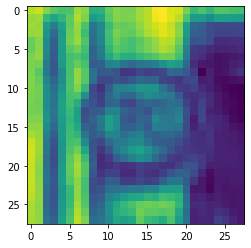

In [17]:
# 첫번째 표본
plt.imshow(dataset.X[0, :, :, :].reshape(RESIZED_IMAGE))
# 레이블
print(dataset.y[0, :])

[[0. 0. 0. 0. 0. 1.]]


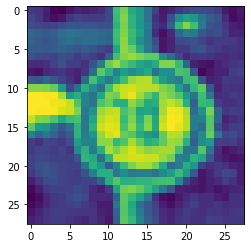

In [18]:
# 마지막 표본
plt.imshow(dataset.X[-1, :, :, :].reshape(RESIZED_IMAGE))
# 레이블
print(dataset.y[-1, :])

In [19]:
# train/test 데이터셋 분류
from sklearn.model_selection import train_test_split

idx_train, idx_test = train_test_split(range(dataset.X.shape[0]), test_size = 0.25, random_state = 101 )

In [21]:
# idx_train

In [23]:
# idx_test

In [24]:
len(idx_train), len(idx_test)

(2334, 779)

In [25]:
X_train = dataset.X[idx_train, :, :, :]
X_test = dataset.X[idx_test, :, :, :]
y_train = dataset.y[idx_train, :]
y_test = dataset.y[idx_test, :]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2334, 28, 28, 1)
(779, 28, 28, 1)
(2334, 6)
(779, 6)


In [26]:
# 훈련 데이터의 미니배치 생성

def minibatcher(X, y, batch_size, shuffle) :
    assert X.shape[0] == y.shape[0]
    n_samples = X.shape[0]
    
    if shuffle :
        idx = np.random.permutation(n_samples)
    else :
        idx = list(range(n_samples))
        
    for k in range(int(np.ceil(n_samples / batch_size))) :
        from_idx = k * batch_size
        to_idx = (k+1) * batch_size
        yield X[idx[from_idx:to_idx], :, :, :], y[idx[from_idx:to_idx], :]

In [27]:
for mb in minibatcher(X_train, y_train, 1000, True) :
    print(mb[0].shape, mb[1].shape)

(1000, 28, 28, 1) (1000, 6)
(1000, 28, 28, 1) (1000, 6)
(334, 28, 28, 1) (334, 6)


### 모델 구성

In [ ]:
# optimizer : AdamOptimizer

In [28]:
# hyperparameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [29]:
# 모델 생성 함수
def build_model(X) :
    
    # Layer1 / ImgIn shape = (?, 28, 28, 1)
    # kernel_size = [3, 3], filters = 32
    W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev = 0.01))
    L1 = tf.nn.conv2d(X, W1, strides = [1, 1, 1, 1], padding = 'SAME')
    L1 = tf.nn.relu(L1)
    L1 = tf.nn.max_pool(L1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    L1 = tf.nn.dropout(L1, keep_prob = keep_prob)
    
    # Layer2 / ImgIn shape = (?, 14, 14, 32)
    # kernel_size = [3, 3], filters = 64 
    W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev = 0.01))
    L2 = tf.nn.conv2d(L1, W2, strides = [1, 1, 1, 1], padding = 'SAME')
    L2 = tf.nn.relu(L2)
    L2 = tf.nn.max_pool(L2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    L2 = tf.nn.dropout(L2, keep_prob = keep_prob)
    
    # Layer3 / ImgIn shape = (?, 7, 7, 64)
    # kernel_size = [3, 3], filters = 128 
    W3 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev = 0.01))
    L3 = tf.nn.conv2d(L2, W3, strides = [1, 1, 1, 1], padding = 'SAME')
    L3 = tf.nn.relu(L3)
    L3 = tf.nn.max_pool(L3, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    L3 = tf.nn.dropout(L3, keep_prob = keep_prob)
    L3_flat = tf.reshape(L3, [-1, 128 * 4 * 4])
    
    # Layer4 / FC 4x4x128 inputs -> 625 outputs
    W4 = tf.get_variable("W4", shape = [128 * 4 * 4, 625], initializer=tf.contrib.layers.xavier_initializer())
    b4 = tf.Variable(tf.random_normal([625]))
    L4 = tf.nn.relu(tf.matmul(L3_flat, W4) + b4)
    L4 = tf.nn.dropout(L4, keep_prob = keep_prob)
    
    # Layer5 / Final FC 625 inputs -> (N_CLASSES) outputs
    W5 = tf.get_variable("W5", shape = [625, N_CLASSES], initializer=tf.contrib.layers.xavier_initializer())
    b5 = tf.Variable(tf.random_normal([N_CLASSES]))
    logits = tf.matmul(L4, W5) + b5
    y_pred = tf.nn.softmax(logits)
    
    return y_pred, logits

In [30]:
# dropout (keep_prob) rate  0.7~0.5 on training, but should be 1 for testing
keep_prob = tf.placeholder(tf.float32)

# input placeholders
X = tf.placeholder(tf.float32, [None, RESIZED_IMAGE[0], RESIZED_IMAGE[1], 1])
y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [31]:
y_pred, logits = build_model(X)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [32]:
# define cost/loss & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### 모델 학습 및 저장

In [37]:
CHECK_POINT_DIR = './model.ckpt'
if not os.path.exists(CHECK_POINT_DIR) :
    os.makedirs(CHECK_POINT_DIR)

In [38]:
checkpoint = tf.train.get_checkpoint_state(CHECK_POINT_DIR)
if checkpoint :
    print(checkpoint)
    print(checkpoint.model_checkpoint_path)

In [39]:
# save model
saver = tf.train.Saver()

In [40]:
# initialize
config = ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [41]:
# load a trained model
if checkpoint and checkpoint.model_checkpoint_path :
    try : 
        # saver = tf.train.import_meta_graph(checkpoint.model_checkpoint_path + '.meta')
        saver.restore(sess, checkpoint.model_checkpoint_path)
        print('Successfully loaded : ', checkpoint.model_checkpoint_path)
    except :
        print("Error on loading old network weights")
else :
    print("Could not find old network weights")

Could not find old network weights


In [42]:
# train
for epoch in range(training_epochs) :
    print("Epoch = ", epoch)
    costs = []
    # total_batch = int(len(idx_train) / batch_size)

    for mb in minibatcher(X_train, y_train, batch_size, True) :
        feed_dict = {X : mb[0], y : mb[1], keep_prob : 0.7}
        c, _ = sess.run([cost, optimizer], feed_dict = feed_dict)
        # avg_cost += c / total_batch
        costs.append(c)
    # print('Epoch : ', '%04d' % (epoch + 1), 'cost = ', '{:.9f}'.format(avg_cost))
    print('cost = ', np.mean(costs))

Epoch =  0
cost =  1.87913
Epoch =  1
cost =  1.6075581
Epoch =  2
cost =  1.462058
Epoch =  3
cost =  1.3100686
Epoch =  4
cost =  1.2500901
Epoch =  5
cost =  1.1022583
Epoch =  6
cost =  0.99249554
Epoch =  7
cost =  0.89886445
Epoch =  8
cost =  0.7527895
Epoch =  9
cost =  0.6094238
Epoch =  10
cost =  0.5131578
Epoch =  11
cost =  0.45621276
Epoch =  12
cost =  0.39276123
Epoch =  13
cost =  0.3508235
Epoch =  14
cost =  0.35895577


In [43]:
saver.save(sess, CHECK_POINT_DIR + '/model')
print('Trained Model Saved.')

Trained Model Saved.


### 예측

In [44]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [45]:
print('accuracy : ', sess.run(accuracy, feed_dict = {X : X_test, y : y_test, keep_prob : 1}))

accuracy :  0.8934531


In [46]:
print(sess.run(y_pred, feed_dict = {X : X_test, keep_prob : 1}))

[[9.6470124e-01 1.4554402e-04 1.3916723e-05 3.0380636e-02 3.0469768e-05
  4.7281906e-03]
 [7.7575431e-05 5.2018834e-07 5.8970477e-07 4.6290508e-03 1.1624193e-04
  9.9517596e-01]
 [9.5407281e-04 9.3421835e-01 4.6715058e-02 1.6275560e-02 4.6397799e-05
  1.7905559e-03]
 ...
 [1.7669652e-01 3.9169221e-04 4.0459284e-04 5.0381288e-02 1.9433964e-02
  7.5269192e-01]
 [2.9700306e-01 6.1947521e-04 3.2590409e-03 1.9977514e-01 4.2671093e-01
  7.2632357e-02]
 [1.9839780e-02 7.4804575e-07 3.8900794e-06 9.9184595e-02 8.7098932e-01
  9.9816751e-03]]


In [47]:
pred_num = list(sess.run(tf.argmax(y_pred, axis = 1), feed_dict = {X : X_test, keep_prob : 1}))
pred_name = []
for num in pred_num :
    pred_name.append(IDX_LABEL[num])

In [49]:
# pred_num

### 시각화

In [50]:
# classification_report
print(classification_report(sess.run(tf.argmax(y_test, 1)), 
                            sess.run(tf.argmax(y_pred, 1), feed_dict = {X : X_test, keep_prob : 1})))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       180
           1       0.91      0.93      0.92        42
           2       0.95      0.96      0.95        75
           3       0.95      0.76      0.84       204
           4       0.74      0.98      0.84       108
           5       0.96      0.88      0.92       170

    accuracy                           0.89       779
   macro avg       0.90      0.91      0.90       779
weighted avg       0.90      0.89      0.89       779



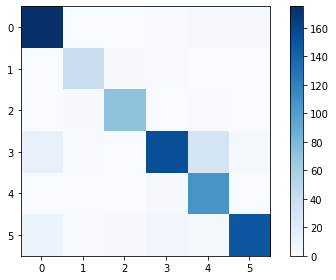

In [51]:
# confusion_matrix(혼동행렬)
cm = confusion_matrix(sess.run(tf.argmax(y_test, 1)), 
                            sess.run(tf.argmax(y_pred, 1), feed_dict = {X : X_test, keep_prob : 1}))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.tight_layout()
plt.show()

In [52]:
# 세션 종료
sess.close()